In [14]:
%matplotlib inline

<div class="document" id="gabor-filter-banks-for-texture-classification">
<h1 class="title">Gabor filter banks for texture classification</h1>
<p>In this example, we will see how to classify textures based on Gabor filter
banks. Frequency and orientation representations of the Gabor filter are similar
to those of the human visual system.</p>
<p>The images are filtered using the real parts of various different Gabor filter
kernels. The mean and variance of the filtered images are then used as features
for classification, which is based on the least squared error for simplicity.</p>
</div>


In [15]:
from __future__ import print_function

% pylab inline

from scipy import ndimage as nd
from scipy.misc import imresize

from scipy.signal import convolve2d

from skimage import data
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [16]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = nd.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats
def match(feats, ref_feats):
    min_error = np.inf
    min_i = None
    for i in range(ref_feats.shape[0]):
        error = np.sum((feats - ref_feats[i, :])**2)
        if error < min_error:
            min_error = error
            min_i = i
    return min_i

def power(image, kernel):
    # Normalize images for better comparison.
    image = (image - image.mean()) / image.std()
    return np.sqrt(nd.convolve(image, np.real(kernel), mode='wrap')**2 +
                   nd.convolve(image, np.imag(kernel), mode='wrap')**2)

# Make a bunch of kernels

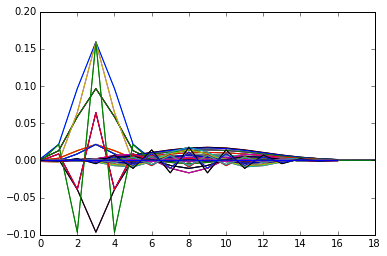

In [17]:
# prepare filter bank kernels
kernels = []
for theta in range(6):
    theta = theta / 6. * np.pi
    for sigma in (1, 3):
        for frequency in [1]:
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)
fig = plt.Figure(figsize=(10,8))            
for k in np.array(kernels):
    ax = plt.plot(k)


# Load images

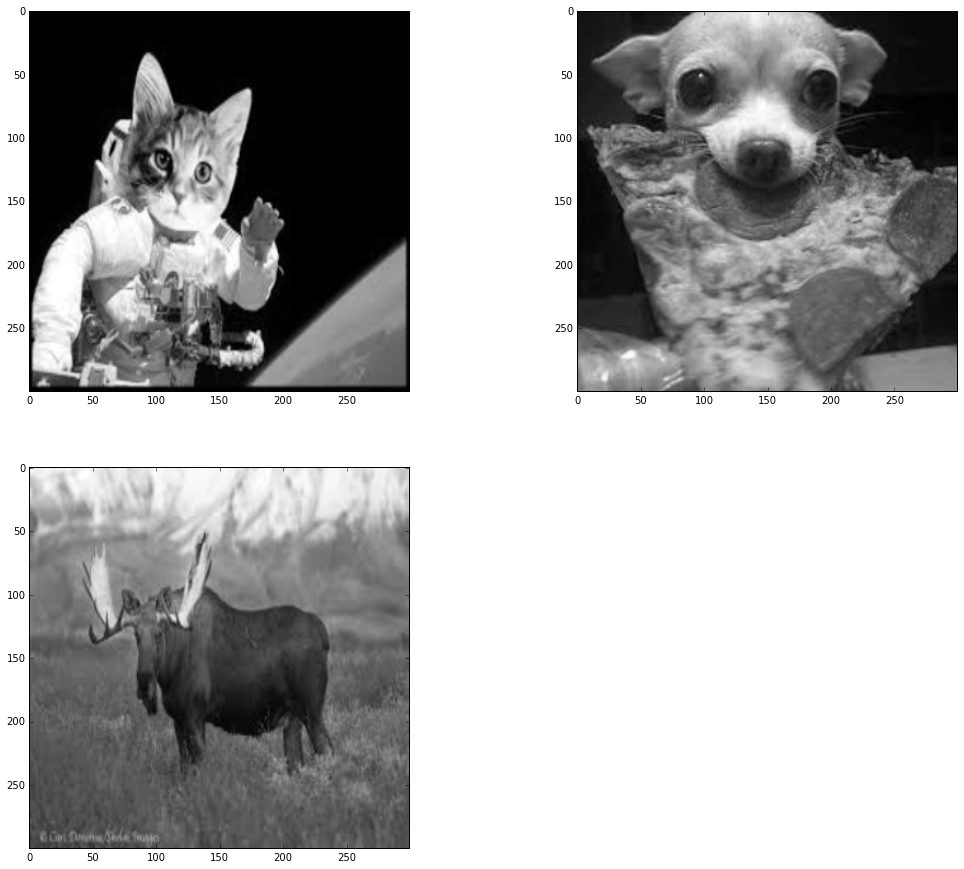

In [18]:
# function to black and white and resize an image
def bw(img):
    from skimage.color import rgb2gray
    return imresize(rgb2gray(img),(300,300))

cat = bw(img_as_float(data.load('/home/nick/books/images/cat.jpg')))
pizza = bw(img_as_float(data.load('/home/nick/books/images/pizza.jpg')))
moose = bw(img_as_float(data.load('/home/nick/books/images/moose.jpg')))

image_names = ('cat', 'pizza','moose')
images = (cat,pizza,moose)


from pylab import rcParams
rcParams['figure.figsize'] = 18,15
plt.subplot(221)
plt.imshow(cat)
plt.subplot(222)
plt.imshow(pizza)
plt.subplot(223)

plt.imshow(moose)


# For k in kernels : 
    feats[k,0] = mean(img * kernel)
    feats[k,1] =  var(img * kernel)

In [19]:
# prepare reference features
ref_feats = np.zeros((len(images), len(kernels), 2), dtype=np.double)
ref_feats[0, :, :] = compute_feats(images[0], kernels)
ref_feats[1, :, :] = compute_feats(images[1], kernels)
ref_feats[2, :, :] = compute_feats(images[2], kernels)


print('Rotated images matched against references using Gabor filter banks:')

print('original: brick, rotated: 30deg, match result: ', end='')
feats = compute_feats(nd.rotate(images[0], angle=190, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

print('original: brick, rotated: 70deg, match result: ', end='')
feats = compute_feats(nd.rotate(images[1], angle=70, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

print('original: grass, rotated: 145deg, match result: ', end='')
feats = compute_feats(nd.rotate(images[2], angle=145, reshape=False), kernels)
print(image_names[match(feats, ref_feats)])

Rotated images matched against references using Gabor filter banks:
original: brick, rotated: 30deg, match result: cat
original: brick, rotated: 70deg, match result: pizza
original: grass, rotated: 145deg, match result: pizza


# Normal

In [20]:
# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
for theta in (0, 1,2,3 ):
    theta = theta / 4. * np.pi
    for frequency in (0.1, 0.2,0.3,0.4,0.5):
        kernel = gabor_kernel(frequency, theta=theta)
        params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append((kernel, [power(img, kernel) for img in images]))



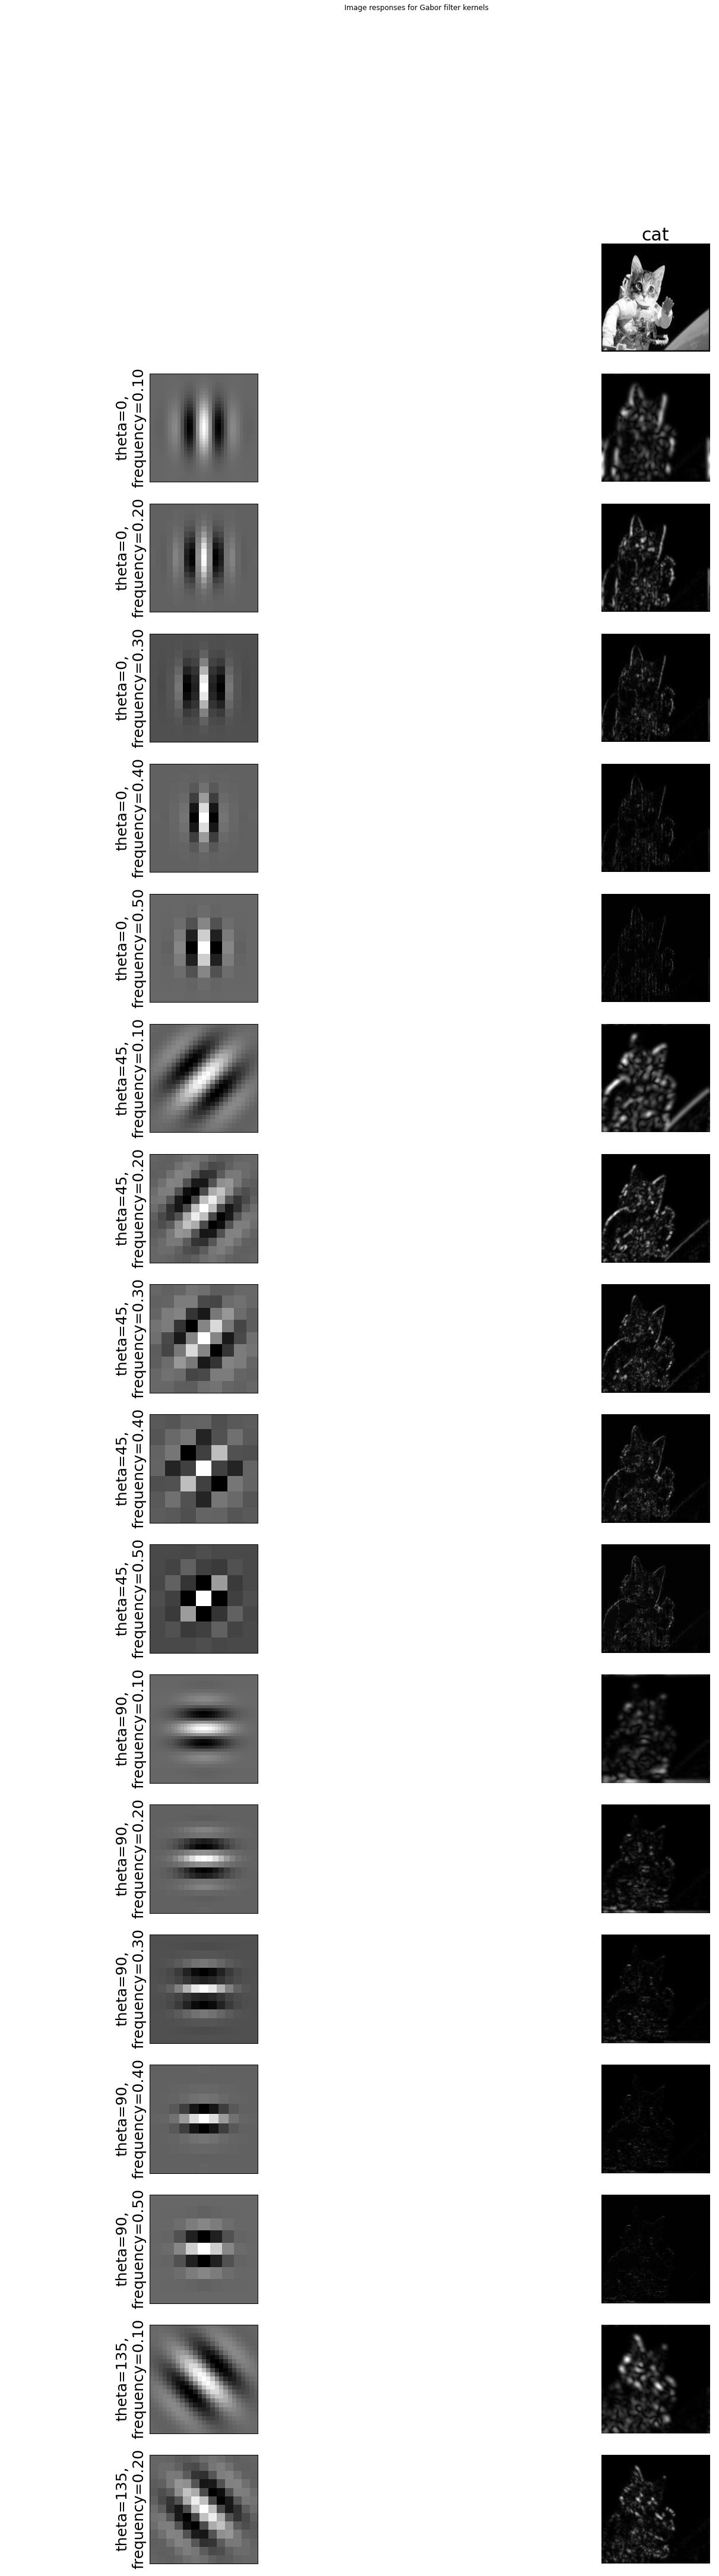

In [21]:
fig, axes = plt.subplots(nrows=18, ncols=2, figsize=(25, 70))
plt.gray()

fig.suptitle('Image responses for Gabor filter kernels', fontsize=12)

axes[0][0].axis('off')

#Plot original images
for label, img, ax in zip(image_names, images, axes[0][1:]):
    ax.imshow(img)
    ax.set_title(label, fontsize=30)
    ax.axis('off')

for label, (kernel, powers), ax_row in zip(kernel_params, results, axes[1:]):
    # Plot Gabor kernel
    ax = ax_row[0]
    ax.imshow(np.real(kernel), interpolation='nearest')
    ax.set_ylabel(label, fontsize=25)
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot Gabor responses with the contrast normalized for each filter
    vmin = np.min(powers)
    vmax = np.max(powers)
    for patch, ax in zip(powers, ax_row[1:]):
        ax.imshow(patch, vmin=vmin, vmax=vmax)
        ax.axis('off')
plt.savefig('/home/nick/books/plot')


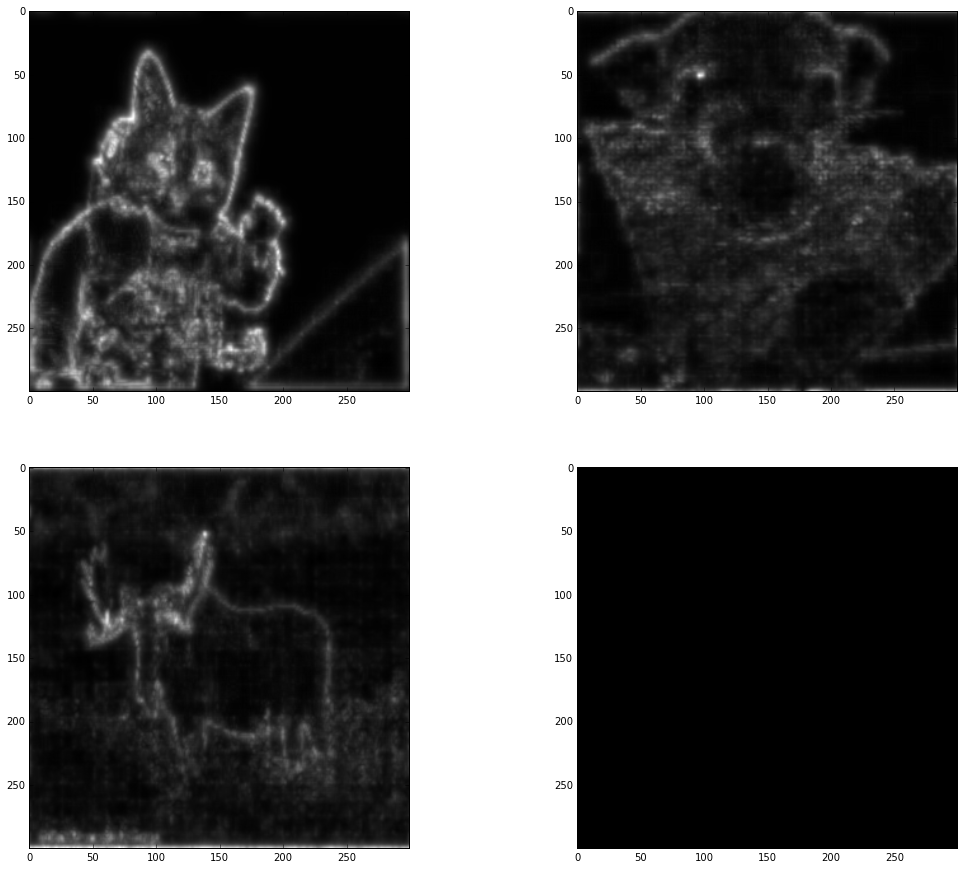

In [22]:
s = [np.zeros((300,300)) for i in xrange(4)]

for kernel, powers in results:
    s[0] += powers[0]
    s[1] += powers[1]
    s[2] += powers[2]
for i in range(4):
    plt.subplot(221 + i)
    imshow(s[i])

In [23]:
# Plot a selection of the filter bank kernels and their responses.
results = []
kernel_params = []
theta = 2 / 4. * np.pi
for frequency in (0.1, 0.2,0.3,0.4,0.5):
    kernel = gabor_kernel(frequency, theta=theta)
    params = 'theta=%d,\nfrequency=%.2f' % (theta * 180 / np.pi, frequency)
    kernel_params.append(params)
    # Save kernel and the power image for each image
    results.append((kernel, [power(img, kernel) for img in images]))



In [24]:
s = [np.zeros((300,300)) for i in xrange(4)]

for kernel, powers in results:
    s[0] += powers[0]
    s[1] += powers[1]
    s[2] += powers[2]
    s[3] += powers[3]
for i in range(4):
    plt.subplot(221 + i)
    imshow(s[i])

IndexError: list index out of range